In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [3]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [4]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [18]:
DLC_social_1 = get_coordinates(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                               p=16,                              #Number of processes used for parallelization
                               smooth_alpha=0,                    #Alpha value for exponentially weighted smoothing
                               distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                                          'B_Right_flank','B_Tail_base'],
                               ego='B_Center',
                               angles=True,
                               connectivity=bp_dict,
                               arena='circular',                  #Type of arena used in the experiments
                               arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                               video_format='.mp4',
                               table_format='.h5',
                               exp_conditions=Treatment_dict)

In [19]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)

Loading and smoothing trajectories...
Done!
CPU times: user 7.43 s, sys: 795 ms, total: 8.23 s
Wall time: 8.26 s


In [20]:
%%time
test = DLC_social_1_coords.get_coords(center=False, polar=False)
test._type

CPU times: user 44.9 ms, sys: 20.8 ms, total: 65.7 ms
Wall time: 64.9 ms


'coords'

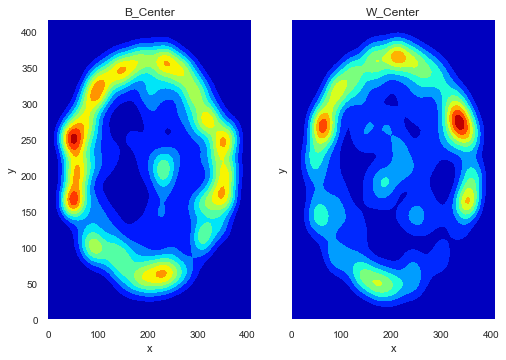

In [8]:
test.plot_heatmaps(['B_Center', 'W_Center'], i=2)

In [22]:
%%time
test = DLC_social_1_coords.get_distances()
test._type

CPU times: user 24 µs, sys: 1 µs, total: 25 µs
Wall time: 27.2 µs


'dist'

In [11]:
%%time
test = DLC_social_1_coords.get_angles(degrees=False)
test._type

CPU times: user 382 µs, sys: 9.55 ms, total: 9.93 ms
Wall time: 9.93 ms


'angles'

# Distance computing draft 

In [ ]:
example = DLC_social_1_coords.get_coords(center=False, polar=False)

In [ ]:
from numpy.core.umath_tests import inner1d
def compute_dist(pair_df, arena_abs, arena_rel):
    a,b = pair_df[:,:2], pair_df[:,2:]
    ab = a-b
    dist = np.sqrt(inner1d(ab,ab))
    return pd.DataFrame(dist * arena_abs / arena_rel)

In [ ]:
def bpart_distance(dataframe, arena_abs, arena_rel):
    
    indexes = combinations(dataframe.columns.levels[0], 2)
    
    dists = []
    for idx in indexes:
        dist = compute_dist(np.array(dataframe.loc[:,list(idx)]), arena_abs, arena_rel)
        dist.columns = [idx]
        dists.append(dist)
        
    return pd.concat(dists, axis=1)

In [ ]:
def get_distances(table_dict):
    return {key:bpart_distance(tab,
                               DLC_social_1_coords.get_arenas[2][i,3],
                               DLC_social_1_coords.get_arenas[2][i,2]) for i,(key,tab) in enumerate(table_dict.items())}    

In [ ]:
%%time
get_distances(example)

In [ ]:
test['Day2Test13DLC'][('B_Center', 'B_Nose')]

In [ ]:
[[i,j,k] for i,(j,k) in enumerate(example.items())]